# CTA Style Long-Term Eurodollar Momentum


# NOTES:

# Continuous time-series:
Backtests are computed using Bloombergs generic continuous futures time series (last traded price) which may skew results compared to those obtained by manually rolling the contracts. 

# Costs and Fees:
Backtests are computed assuming $\textit{zero}$ costs and fees.


In [1]:
from src.data_request import BloombergAPI
from datetime import datetime
import pandas as pd
import numpy  as np

import warnings
warnings.filterwarnings('ignore')

index_specifications = {'ED1 Comdty' :{'Symbol': 'ED1 Comdty','EWMA_window':400, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ED2 Comdty' :{'Symbol': 'ED2 Comdty','EWMA_window':400, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ED3 Comdty' :{'Symbol': 'ED3 Comdty','EWMA_window':400, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ED4 Comdty' :{'Symbol': 'ED4 Comdty','EWMA_window':400, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ER1 Comdty' :{'Symbol': 'ER1 Comdty','EWMA_window':700, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ER2 Comdty' :{'Symbol': 'ER2 Comdty','EWMA_window':700, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ER3 Comdty' :{'Symbol': 'ER3 Comdty','EWMA_window':700, 'Vol_window':400, 'Signal_Scaling': 10    },
                        'ER4 Comdty' :{'Symbol': 'ER4 Comdty','EWMA_window':700, 'Vol_window':400, 'Signal_Scaling': 10    }
                       }

symbols    = [ index_specifications[s]['Symbol'] for s in list(index_specifications.keys())]

benchmarks = ['JHLXH3US Index']

In [2]:
print('Selected symbols are: ',symbols)

Selected symbols are:  ['ED1 Comdty', 'ED2 Comdty', 'ED3 Comdty', 'ED4 Comdty', 'ER1 Comdty', 'ER2 Comdty', 'ER3 Comdty', 'ER4 Comdty']


# Data Exploration

The data we use here comes from Bloomberg. The code below utilizes the Bloombergs Python API to pull data directly from Bloombergs servers. After downloading the data lets plot the it to make sure it makes sense :)

In [3]:
# Download data for traded instruments
data_handler = BloombergAPI(SERVER_HOST='localhost',SERVER_PORT=8194)
start_date   = datetime(1995,1,5)
end_date     = datetime.today()
price_data   = []
for symbol in symbols:
    print('Downloading data for symbol :',symbol)
    try:
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            price_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")
price_data       = pd.concat(price_data,axis=1)
price_data.index = pd.DatetimeIndex(price_data.index)

# Download data for benchmark indices
benchmark_data   = []
for symbol in benchmarks:
    print('Downloading data for symbol :',symbol)
    try:
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            benchmark_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")
benchmark_data = pd.concat(benchmark_data,axis=1)
benchmark_data.index = pd.DatetimeIndex(benchmark_data.index)

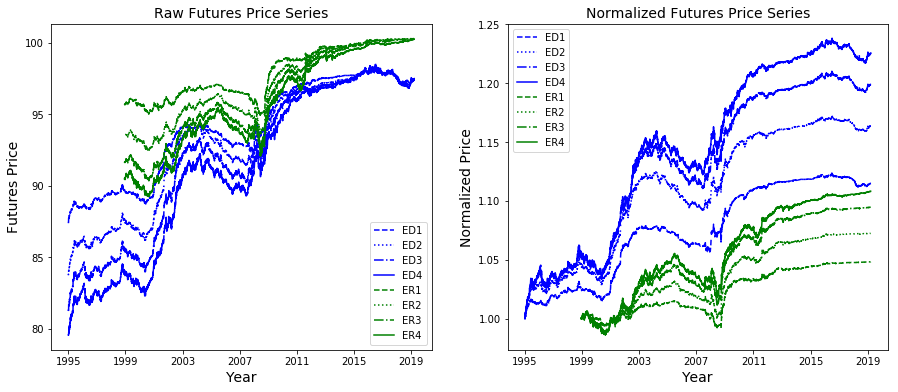

In [5]:
# Lets plot the data
import matplotlib.pyplot as plt

# Plot for raw time series
fig,ax = plt.subplots(1,2,figsize=(15,6))

# Raw futures price series
# ------------------------
# Eurodollars
ax[0].plot(price_data["ED1 Comdty"], ls = '--', color = 'blue', label = "ED1")
ax[0].plot(price_data["ED2 Comdty"], ls = ':' , color = 'blue', label = "ED2")
ax[0].plot(price_data["ED3 Comdty"], ls = '-.', color = 'blue', label = "ED3")
ax[0].plot(price_data["ED4 Comdty"], ls = '-' , color = 'blue', label = "ED4")
# Euribors
ax[0].plot(price_data["ER1 Comdty"], ls = '--', color = 'green', label = "ER1")
ax[0].plot(price_data["ER2 Comdty"], ls = ':' , color = 'green', label = "ER2")
ax[0].plot(price_data["ER3 Comdty"], ls = '-.', color = 'green', label = "ER3")
ax[0].plot(price_data["ER4 Comdty"], ls = '-' , color = 'green', label = "ER4")

ax[0].set_ylabel('Futures Price',fontsize=14)
ax[0].set_xlabel('Year',fontsize=14)
ax[0].set_title('Raw Futures Price Series',fontsize=14)
ax[0].legend(loc=4)

# Normalized futures price series
# ------------------------
# Eurodollars
ax[1].plot(price_data["ED1 Comdty"].div(price_data["ED1 Comdty"].iloc[0]), ls = '--', color = 'blue', label = "ED1")
ax[1].plot(price_data["ED2 Comdty"].div(price_data["ED2 Comdty"].iloc[0]), ls = ':' , color = 'blue', label = "ED2")
ax[1].plot(price_data["ED3 Comdty"].div(price_data["ED3 Comdty"].iloc[0]), ls = '-.', color = 'blue', label = "ED3")
ax[1].plot(price_data["ED4 Comdty"].div(price_data["ED4 Comdty"].iloc[0]), ls = '-' , color = 'blue', label = "ED4")

# Euribors
y1 = price_data["ER1 Comdty"].dropna()
y2 = price_data["ER2 Comdty"].dropna()
y3 = price_data["ER3 Comdty"].dropna()
y4 = price_data["ER4 Comdty"].dropna()

ax[1].plot(y1.div(y1.iloc[0]), ls = '--', color = 'green', label = "ER1")
ax[1].plot(y2.div(y2.iloc[0]), ls = ':' , color = 'green', label = "ER2")
ax[1].plot(y3.div(y3.iloc[0]), ls = '-.', color = 'green', label = "ER3")
ax[1].plot(y4.div(y4.iloc[0]), ls = '-' , color = 'green', label = "ER4")

ax[1].set_ylabel('Normalized Price',fontsize=14)
ax[1].set_xlabel('Year',fontsize=14)
ax[1].set_title('Normalized Futures Price Series',fontsize=14)
ax[1].legend(loc=2)


# Momentum Signal Definitions

The momentum signal for some asset $i$ is here defined as the simple average of scaled individual signals. The process of computing the scaled signals begins by first computing raw unscaled signals. These unscaled signals are then scaled using some normalization method.

### Signal 1:

The first signal that we test is simple average of realized Sharpe ratios. Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w$ returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{i,t-j}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$


### Signal 2:
 
The second signal is computed like Signal 1 but we impose extra cutoff level of $\xi$. In other words - we trade only when the signal is strong enough.

$$s_{w}(t)=\left\{\begin{matrix}
s_{w}(t), \left | s_{w}(t) \right | \geq \xi \\ 
0
\end{matrix}\right.$$


### Signal 3:
Like signal 1 but with total returns.



### Signal 4:
Signal 4 is such that between +-20% proportional to signal, if over +-20% in absolute value the signal is +-100%.

$$s_{w}(t)=\left\{\begin{matrix}
+100\% , s_{w}(t) > 20\% \\ 
s_{w}(t) , \left| s_{w}(t) \right| \leq 20\% \\ 
-100\% , s_{w}(t) < -20\%
\end{matrix}\right.$$


### Signal 5:
Signal 5 is based on the cross over of short and longer exponentially weighted moving averages of the futures $\textit{prices}$. The algorithm building this signal involves several steps:

(a) Select 3 sets of time-scales with each set consisting of a short and a long ewmas.

(b) Here, we use the same specs as in MAN AHLs paper (link below). Let

$$S_k=\left( 8,16,32\right)$$
$$L_k=\left( 24,48,96\right)$$

These numbers are not look-back days or half-lifes but translate into EWMA decay factors $\lambda(n) = \frac{n-1}{n}$. So decay for the first short EWMA is $\lambda(S_1) = \frac{S_1-1}{S_1} = \frac{8-1}{8}$. Using this decay factor we compute the half-life of the EWMA:

$$HL(n) = \frac{log(0.5)}{log(\lambda(n))}$$

(c) Once we have obtained HLs for $S_k$ and $L_k$ we compute the cross over magnitudes $x_k$ in the usual manner:

$$x_k = EWMA\left(P|S_k\right) - EWMA\left(P|L_k\right)$$

where $P$ is the time-series for the price of the futures.

(d) The raw cross over signals $x_k$ is then normalized using a moving standard deviation of the $\textit{futures}$ $\textit{price}$ which is computed over 63-trading days:

$$y_k = \frac{x_k}{\sigma(P)_{63}}$$

Shameless plug warning:  https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf

(e) The standardized signal $y_k$ is standardized again using its own standard deviation computed over 252 trading days:

$$z_k = \frac{y_k}{\sigma(y_k)_{252}}$$

(f) The final signal $s$ is obtained by averaging the three standardized signals:

$$s=\frac{1}{3}\sum_{k=1}^{3} z_k $$

(g) Finally, we truncate the signal $s\in \left[ -1;1\right]$


In [6]:
def signal_1(symbol,returns,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        mu = returns.rolling(w).mean()
        s  = (mu.div(mu.rolling(sigma_lookback_window).std())).clip(-1,1)
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1).to_frame()
    df.columns = [symbol]
    return df
    
def signal_2(symbol,returns,return_lookback_windows,sigma_lookback_window,cutoff):
    s_2 = signal_1(symbol,returns,return_lookback_windows,sigma_lookback_window)
    s_2[abs(s_2)<cutoff] = 0
    return s_2


def signal_3(symbol,price_data,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        r_w   = price_data.pct_change(w)
        sigma = r_w.rolling(sigma_lookback_window).std()
        s     = (r_w.div(sigma)).clip(-1,1)
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1).to_frame()
    df.columns = [symbol]        
    return df

def signal_4(symbol,returns,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        mu    = returns.ewm(w).mean()   
        sigma = mu.ewm(sigma_lookback_window).std()
        s     = mu.div(sigma)
        s[s> 0.2] =  1
        s[s<-0.2] = -1
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1).to_frame()
    df.columns = [symbol]      
    return df


def signal_5(symbol,price_data,shorter_windows,longer_windows):
    
    if(len(shorter_windows)!=len(longer_windows)):
        raise ValueError('Window lengths must be of equal size!')
    else:
        t = {}
        for i in range(0,len(shorter_windows)):
            n_s_k = shorter_windows[i]
            n_l_k = longer_windows[i]
            lamda_s_k = (n_s_k - 1)/float(n_s_k)
            lamda_l_k = (n_l_k - 1)/float(n_l_k)
            hl_s_k = np.log(0.5)/np.log(lamda_s_k)
            hl_l_k = np.log(0.5)/np.log(lamda_l_k)
            ewma_s_k = price_data.ewm(halflife=hl_s_k,ignore_na=True).mean()
            ewma_l_k = price_data.ewm(halflife=hl_l_k,ignore_na=True).mean()
            x_k = ewma_s_k - ewma_l_k
            y_k = x_k/price_data.ewm(63).std()
            z_k = (y_k/y_k.ewm(250).std()).clip(-1,1)
            t.update({f'{shorter_windows[i]}-{longer_windows[i]}':z_k})
        df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
        df.columns = [symbol]
        return df

In [7]:
# Return computation
ret = price_data.pct_change(1).fillna(0)

# We allocate dictionary for the signal dataframes
momentum_signals = {}

# Signal 1
t = {}
for symbol in symbols:
    mu_w    = index_specifications[symbol]["EWMA_window"]
    sigma_w = index_specifications[symbol]["Vol_window"]
    t.update({symbol:signal_1(symbol,ret[symbol],[mu_w],sigma_w)})
momentum_signals.update({"Signal_1":t})

# Signal 2
t = {}
for symbol in symbols:
    mu_w    = index_specifications[symbol]["EWMA_window"]
    sigma_w = index_specifications[symbol]["Vol_window"]    
    t.update({symbol:signal_2(symbol,ret[symbol],[mu_w],sigma_w,0.65)})
momentum_signals.update({"Signal_2":t})
    
# Signal 3 (Note: we pass price data here - not returns)
t = {}
for symbol in symbols:
    mu_w    = index_specifications[symbol]["EWMA_window"]
    sigma_w = index_specifications[symbol]["Vol_window"]    
    t.update({symbol:signal_3(symbol,price_data[symbol],[mu_w],sigma_w)})
momentum_signals.update({"Signal_3":t})

# Signal 4
t = {}
for symbol in symbols:
    mu_w    = index_specifications[symbol]["EWMA_window"]
    sigma_w = index_specifications[symbol]["Vol_window"]    
    t.update({symbol:signal_4(symbol,ret[symbol],[mu_w],sigma_w)})
momentum_signals.update({"Signal_4":t})

# Signal 5 (Note: we pass price data here - not returns)
t = {}
s_w = [8,16,32]
l_w = [24,48,96]
for symbol in symbols:
    t.update({symbol:signal_5(symbol,price_data[symbol],s_w,l_w)})
momentum_signals.update({"Signal_5":t})


# Signal Time-Series

The plots below show the different signals $\{1,2,3,4,5\}$ for all assets in our basket.

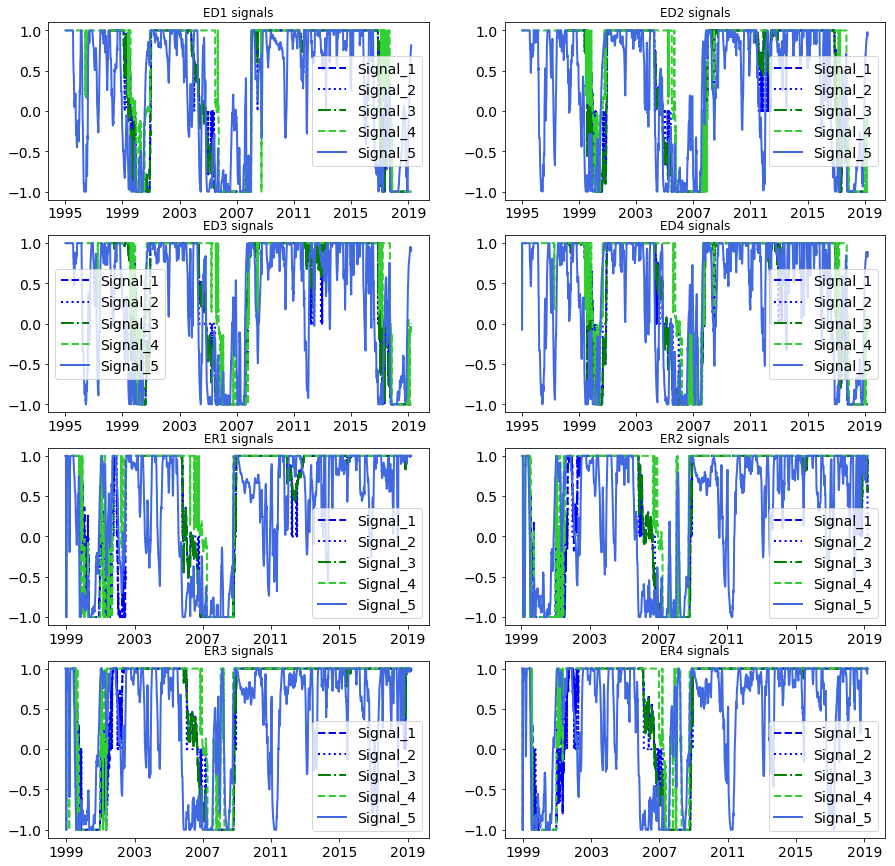

In [9]:
# Plot results
fig, ax = plt.subplots(4, 2, figsize=(15,15))

# Eurodollar futures signals
ax[0, 0].plot(momentum_signals["Signal_1"]['ED1 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[0, 0].plot(momentum_signals["Signal_2"]['ED1 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[0, 0].plot(momentum_signals["Signal_3"]['ED1 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[0, 0].plot(momentum_signals["Signal_4"]['ED1 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[0, 0].plot(momentum_signals["Signal_5"]['ED1 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[0, 0].set_title(f"ED1 signals" )
ax[0, 0].legend(fontsize=14)
ax[0, 0].xaxis.set_tick_params(labelsize=14)
ax[0, 0].yaxis.set_tick_params(labelsize=14)

ax[0, 1].plot(momentum_signals["Signal_1"]['ED2 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[0, 1].plot(momentum_signals["Signal_2"]['ED2 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[0, 1].plot(momentum_signals["Signal_3"]['ED2 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[0, 1].plot(momentum_signals["Signal_4"]['ED2 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[0, 1].plot(momentum_signals["Signal_5"]['ED2 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[0, 1].set_title(f"ED2 signals" )
ax[0, 1].legend(fontsize=14)
ax[0, 1].xaxis.set_tick_params(labelsize=14)
ax[0, 1].yaxis.set_tick_params(labelsize=14)

ax[1, 0].plot(momentum_signals["Signal_1"]['ED3 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[1, 0].plot(momentum_signals["Signal_2"]['ED3 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[1, 0].plot(momentum_signals["Signal_3"]['ED3 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[1, 0].plot(momentum_signals["Signal_4"]['ED3 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[1, 0].plot(momentum_signals["Signal_5"]['ED3 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[1, 0].set_title(f"ED3 signals" )
ax[1, 0].legend(fontsize=14)
ax[1, 0].xaxis.set_tick_params(labelsize=14)
ax[1, 0].yaxis.set_tick_params(labelsize=14)

ax[1, 1].plot(momentum_signals["Signal_1"]['ED4 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[1, 1].plot(momentum_signals["Signal_2"]['ED4 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[1, 1].plot(momentum_signals["Signal_3"]['ED4 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[1, 1].plot(momentum_signals["Signal_4"]['ED4 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[1, 1].plot(momentum_signals["Signal_5"]['ED4 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[1, 1].set_title(f"ED4 signals" )
ax[1, 1].legend(fontsize=14)
ax[1, 1].xaxis.set_tick_params(labelsize=14)
ax[1, 1].yaxis.set_tick_params(labelsize=14)

# Euribor futures signals
ax[2, 0].plot(momentum_signals["Signal_1"]['ER1 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[2, 0].plot(momentum_signals["Signal_2"]['ER1 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[2, 0].plot(momentum_signals["Signal_3"]['ER1 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[2, 0].plot(momentum_signals["Signal_4"]['ER1 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[2, 0].plot(momentum_signals["Signal_5"]['ER1 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[2, 0].set_title(f"ER1 signals" )
ax[2, 0].legend(fontsize=14)
ax[2, 0].xaxis.set_tick_params(labelsize=14)
ax[2, 0].yaxis.set_tick_params(labelsize=14)

ax[2, 1].plot(momentum_signals["Signal_1"]['ER2 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[2, 1].plot(momentum_signals["Signal_2"]['ER2 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[2, 1].plot(momentum_signals["Signal_3"]['ER2 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[2, 1].plot(momentum_signals["Signal_4"]['ER2 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[2, 1].plot(momentum_signals["Signal_5"]['ER2 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[2, 1].set_title(f"ER2 signals" )
ax[2, 1].legend(fontsize=14)
ax[2, 1].xaxis.set_tick_params(labelsize=14)
ax[2, 1].yaxis.set_tick_params(labelsize=14)

ax[3, 0].plot(momentum_signals["Signal_1"]['ER3 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[3, 0].plot(momentum_signals["Signal_2"]['ER3 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[3, 0].plot(momentum_signals["Signal_3"]['ER3 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[3, 0].plot(momentum_signals["Signal_4"]['ER3 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[3, 0].plot(momentum_signals["Signal_5"]['ER3 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[3, 0].set_title(f"ER3 signals" )
ax[3, 0].legend(fontsize=14)
ax[3, 0].xaxis.set_tick_params(labelsize=14)
ax[3, 0].yaxis.set_tick_params(labelsize=14)

ax[3, 1].plot(momentum_signals["Signal_1"]['ER4 Comdty'], label = "Signal_1", color = 'blue' , ls = '--', lw = 2)
ax[3, 1].plot(momentum_signals["Signal_2"]['ER4 Comdty'], label = "Signal_2", color = 'blue' , ls = ':' , lw = 2)
ax[3, 1].plot(momentum_signals["Signal_3"]['ER4 Comdty'], label = "Signal_3", color = 'green' , ls = '-.', lw = 2)
ax[3, 1].plot(momentum_signals["Signal_4"]['ER4 Comdty'], label = "Signal_4", color = 'limegreen'  , ls = '--', lw = 2)
ax[3, 1].plot(momentum_signals["Signal_5"]['ER4 Comdty'], label = "Signal_5", color = 'royalblue'  , ls = '-' , lw = 2)
ax[3, 1].set_title(f"ER4 signals" )
ax[3, 1].legend(fontsize=14)
ax[3, 1].xaxis.set_tick_params(labelsize=14)
ax[3, 1].yaxis.set_tick_params(labelsize=14)

# -------------------------------------------------------------------------------------------

# Signal 1 Performance Backtest

### Signal 1 definition:

The first signal that we test is simple average of realized Sharpe ratios. Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w$ returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{i,t-j}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$


### Nominal exposure

The final trading signal or $\textit{nominal exposure}$ of the strategy is computed using the raw trading signal and by multiplying it by 10.  That is, the total exposure in asset $i$ at time $t$, $E_{t}^{i}$ is defined as:

$$E_{t}^{i}:=10s_{t}^{i}$$

#### NOTE: No volatility scaling is used here

In [10]:
strategy_1_no_vol_scaling = pd.DataFrame(index = ret.index, data = np.zeros_like(ret), columns = ret.columns)

for symbol in symbols:
    
        # Momentum signal
        s = momentum_signals["Signal_1"][symbol]
        s = s*index_specifications[symbol]["Signal_Scaling"]

        # Futures returns
        returns  = ret[symbol].to_frame()
        returns.columns = [symbol]
        
        # Strategy returns
        strategy_1_no_vol_scaling[symbol]  = returns*s.shift(1)              # without volatility scaling
       
        

Text(0.5,1,'Q-Q')

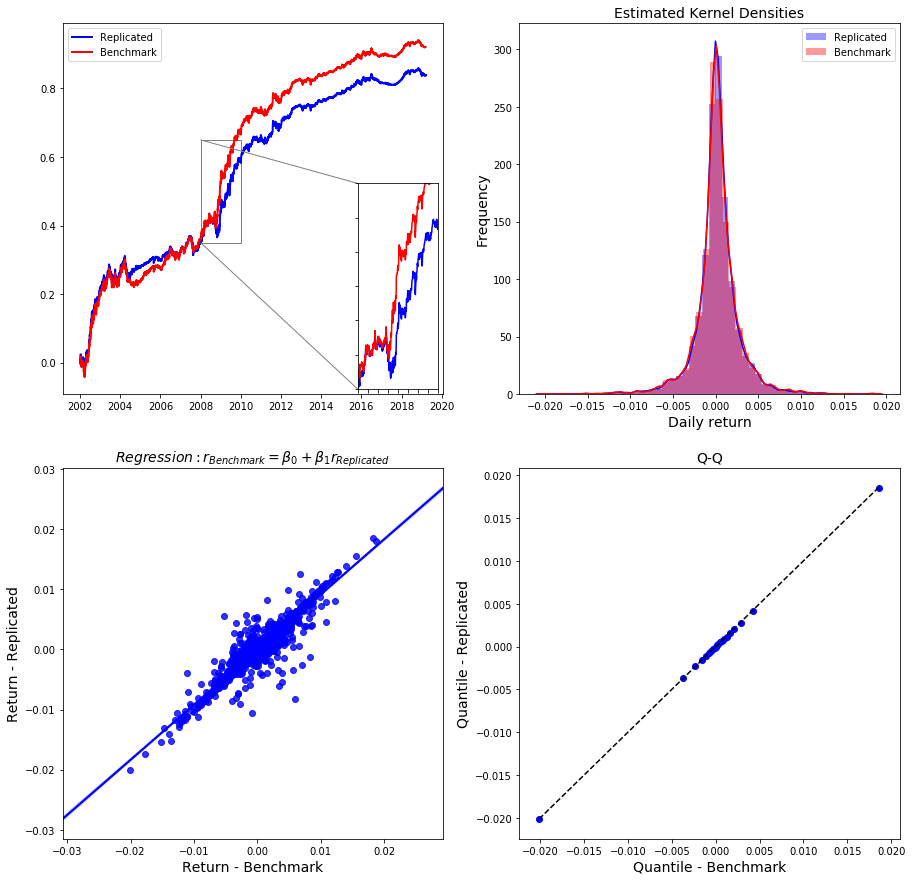

In [51]:
# Plot results
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

start_date  = datetime(2001,12,31)

strategy_1_returns = strategy_1_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_1_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()

fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0, 0].plot(strategy_1_returns.cumsum()  , label = 'Replicated', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax[0, 0], 2,  loc='lower right') # zoom = 2
axins.plot(strategy_1_returns.cumsum(), color = 'blue')
axins.plot(benchmark_returns.cumsum(), color = 'red')
axins.set_ylim(0.35, 0.65)
axins.set_xlim(datetime(2008,1,1),datetime(2010,1,1))
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax[0, 0], axins, loc1=2, loc2=3, fc="none", ec="0.5")



sns.distplot(strategy_1_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated')
sns.distplot(benchmark_returns , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()


x_data = benchmark_returns.fillna(0)
y_data = strategy_1_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)


### Note:
We notice that during 2008 - 2009 the benchmark index has a lucky run and deviates from our replicated index. To study if the tracking error persist we study the performance using returns from 2010 on.

### Performance of Signal 1 after 2010

Text(0.5,1,'Q-Q')

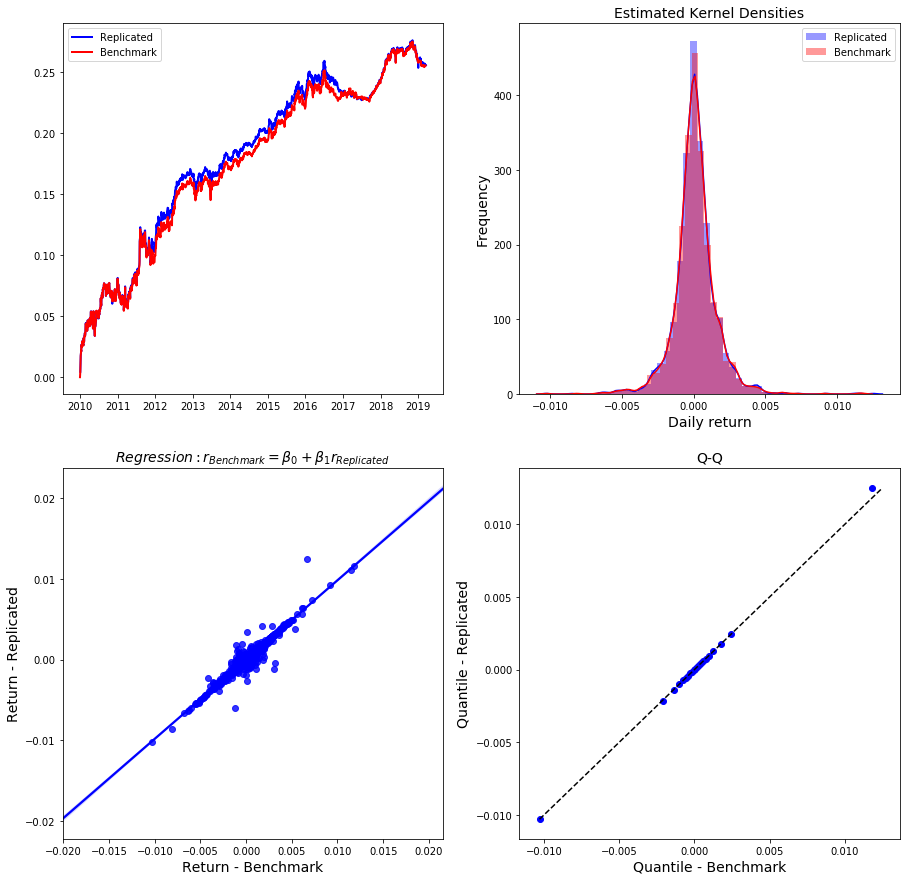

In [55]:
# Plot results
import seaborn as sns

start_date  = datetime(2010,1,1)

strategy_1_returns = strategy_1_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_1_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()

fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0, 0].plot(strategy_1_returns.cumsum()  , label = 'Replicated', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

sns.distplot(strategy_1_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated')
sns.distplot(benchmark_returns , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()


x_data = benchmark_returns.fillna(0)
y_data = strategy_1_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

# -------------------------------------------------------------------------------------------

# Signal 2 Performance Backtest

### Signal 2 definition

The Signal 2 is computed like Signal 1 but we impose extra cutoff level of $\xi$. In other words - we trade only when the signal is strong enough.

$$s_{w}(t)=\left\{\begin{matrix}
s_{w}(t), \left | s_{w}(t) \right | \geq \xi \\ 
0
\end{matrix}\right.$$

The Signal 1 is a simple average of realized Sharpe ratios. Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w$ returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{i,t-j}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$


### Nominal exposure

The final trading signal or $\textit{nominal exposure}$ of the strategy is computed using the raw trading signal and by multiplying it by 10.  That is, the total exposure in asset $i$ at time $t$, $E_{t}^{i}$ is defined as:

$$E_{t}^{i}:=10s_{t}^{i}$$

#### NOTE: No volatility scaling is used here

In [63]:
strategy_2_no_vol_scaling = pd.DataFrame(index = ret.index, data = np.zeros_like(ret), columns = ret.columns)

for symbol in symbols:
    
        # Momentum signal
        s_2 = momentum_signals["Signal_2"][symbol]
        s_2 = s_2*index_specifications[symbol]["Signal_Scaling"]

        # Futures returns
        returns  = ret[symbol].to_frame()
        returns.columns = [symbol]
        
        # Strategy returns
        strategy_2_no_vol_scaling[symbol]  = returns*s_2.shift(1)              # without volatility scaling
       
        

Text(0.5,1,'Q-Q')

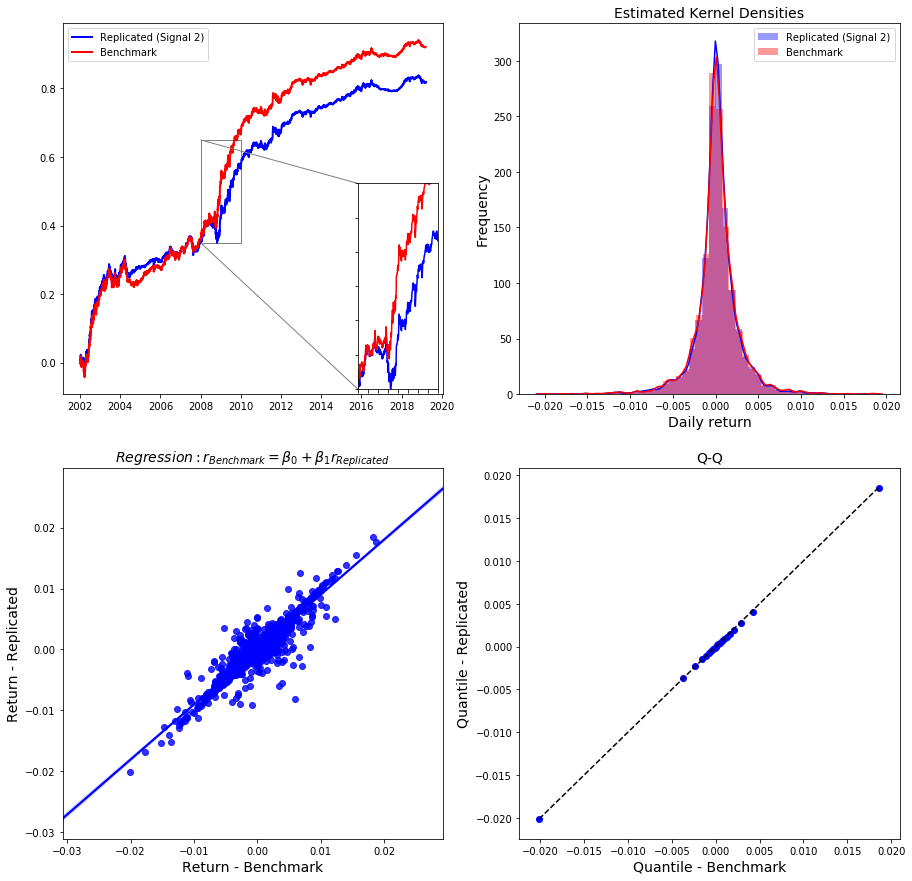

In [64]:
# Plot results
import seaborn as sns

start_date  = datetime(2001,12,31)

strategy_2_returns = strategy_2_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_2_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()


fig, ax = plt.subplots(2, 2, figsize=(15,15))


ax[0, 0].plot(strategy_2_returns.cumsum()  , label = 'Replicated (Signal 2)', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax[0, 0], 2,  loc='lower right') # zoom = 2
axins.plot(strategy_2_returns.cumsum(), color = 'blue')
axins.plot(benchmark_returns.cumsum(), color = 'red')
axins.set_ylim(0.35, 0.65)
axins.set_xlim(datetime(2008,1,1),datetime(2010,1,1))
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax[0, 0], axins, loc1=2, loc2=3, fc="none", ec="0.5")


sns.distplot(strategy_2_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated (Signal 2)')
sns.distplot(benchmark_returns , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()

x_data = benchmark_returns.fillna(0)
y_data = strategy_2_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

### Note:
We notice that during 2008 - 2009 the benchmark index has a lucky run and deviates from our replicated index. To study if the tracking error persist we study the performance using returns from 2010 on.

### Performance of Signal 2 after 2010

Text(0.5,1,'Q-Q')

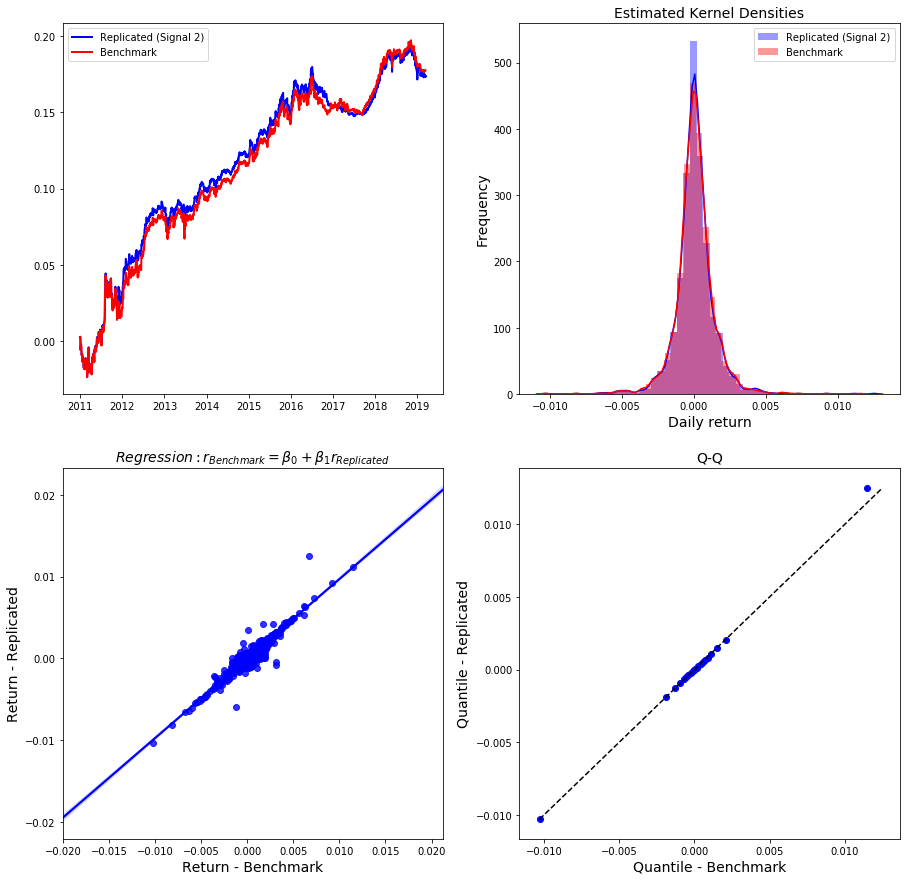

In [65]:
# Plot results
import seaborn as sns

start_date  = datetime(2010,12,31)

strategy_2_returns = strategy_2_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_2_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()


fig, ax = plt.subplots(2, 2, figsize=(15,15))


ax[0, 0].plot(strategy_2_returns.cumsum()  , label = 'Replicated (Signal 2)', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()


sns.distplot(strategy_2_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated (Signal 2)')
sns.distplot(benchmark_returns , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()

x_data = benchmark_returns.fillna(0)
y_data = strategy_2_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

# -------------------------------------------------------------------------------------------

# Signal 3 Performance Backtest

### Signal 3 definition:
The Signal 3 that we test is simple average of realized Sharpe ratios for $\textit{total returns}$.

### N-day return definition:
For the avoidance of doubt we define $N-day$ total-return for asset $i$ at time $t$ as:

$$ r_{t,N}^{i} := \frac{S_{t}^{i}}{S_{t-N}^{i}}-1$$

Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for time $t$, asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w-day$ total-returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{t,N}^{i}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$



### Nominal exposure

The final trading signal or $\textit{nominal exposure}$ of the strategy is computed using the raw trading signal and by multiplying it by 10.  That is, the total exposure in asset $i$ at time $t$, $E_{t}^{i}$ is defined as:

$$E_{t}^{i}:=10s_{t}^{i}$$

#### NOTE: No volatility scaling is used here

In [66]:
strategy_3_no_vol_scaling = pd.DataFrame(index = ret.index, data = np.zeros_like(ret), columns = ret.columns)

for symbol in symbols:
    
        # Momentum signal
        s_3 = momentum_signals["Signal_3"][symbol]
        s_3 = s_3*index_specifications[symbol]["Signal_Scaling"]
        
        # Futures returns
        returns  = ret[symbol].to_frame()
        returns.columns = [symbol]
        
        # Strategy returns
        strategy_3_no_vol_scaling[symbol]  = returns*s_3.shift(1)              # without volatility scaling
  

Text(0.5,1,'Q-Q')

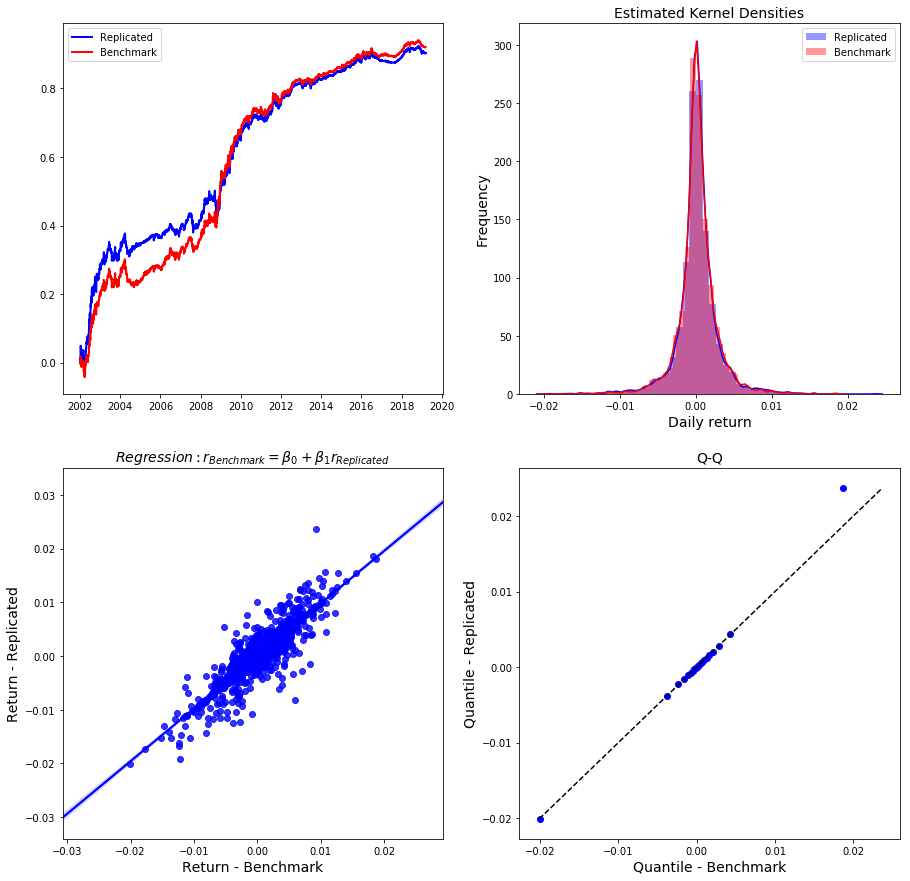

In [67]:
# Plot results
import seaborn as sns

start_date  = datetime(2001,12,31)

strategy_3_returns = strategy_3_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_3_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()


fig, ax = plt.subplots(2, 2, figsize=(15,15))


ax[0, 0].plot(strategy_3_returns.cumsum()  , label = 'Replicated', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

sns.distplot(strategy_3_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated')
sns.distplot(benchmark_returns , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()


x_data = benchmark_returns.fillna(0)
y_data = strategy_3_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

### Note:
We do NOT notice similar performance divergence between the benchmark index and the replicated inxed as in the case of Signal 1 and Signal 2. However, in order to keep the analysis fair and consistent we plot the performance after 2010.

### Performance of Signal 3 after 2010

Text(0.5,1,'Q-Q')

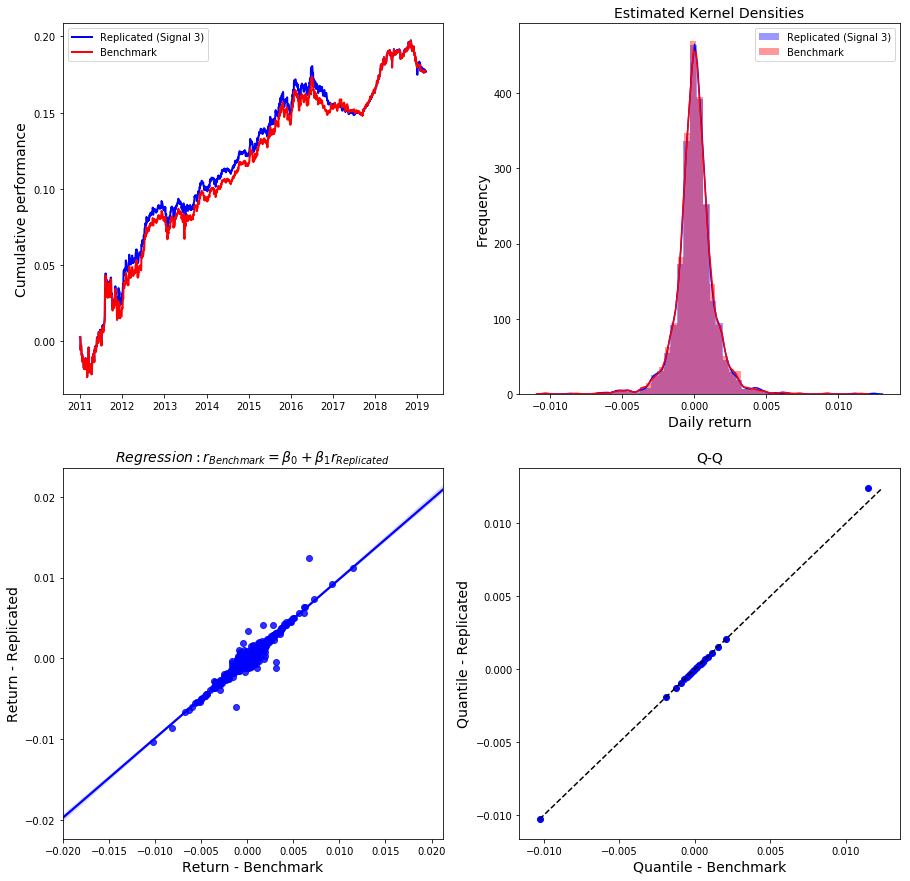

In [77]:
# Plot results
import seaborn as sns

start_date  = datetime(2010,12,31)

strategy_3_returns = strategy_3_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_3_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()

y_1   = strategy_3_returns
y_2   = benchmark_returns 
y_1_c = strategy_3_returns.cumsum()
y_2_c = benchmark_returns.cumsum() 

fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0, 0].plot(y_1_c, label = 'Replicated (Signal 3)', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(y_2_c, label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

sns.distplot(y_1, ax = ax[0,1], color = 'blue', label = f'Replicated (Signal 3)')
sns.distplot(y_2, ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()


x_data = y_2.fillna(0)
y_data = y_1.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

# -------------------------------------------------------------------------------------------

# Signal 4 Performance Backtest

### Signal 4 definition:

Signal 4 is based on Signal 1 but with a special cutoff level such that between +-20% proportional to signal, if over +-20% in absolute value the signal is +-100%.

$$s_{w}(t)=\left\{\begin{matrix}
+100\% , s_{w}(t) > 20\% \\ 
s_{w}(t) , \left| s_{w}(t) \right| \leq 20\% \\ 
-100\% , s_{w}(t) < -20\%
\end{matrix}\right.$$

The Signal 1 is a simple average of realized Sharpe ratios. Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w$ returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{i,t-j}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$



### Nominal exposure

The final trading signal or $\textit{nominal exposure}$ of the strategy is computed using the raw trading signal and by multiplying it by 10.  That is, the total exposure in asset $i$ at time $t$, $E_{t}^{i}$ is defined as:

$$E_{t}^{i}:=10s_{t}^{i}$$

#### NOTE: No volatility scaling is used here

In [72]:
strategy_4_no_vol_scaling = pd.DataFrame(index = ret.index, data = np.zeros_like(ret), columns = ret.columns)

for symbol in symbols:
    
        # Momentum signal
        s_4 = momentum_signals["Signal_4"][symbol]
        s_4 = s_4*index_specifications[symbol]["Signal_Scaling"]
        
        # Futures returns
        returns  = ret[symbol].to_frame()
        returns.columns = [symbol]
        
        # Strategy returns
        strategy_4_no_vol_scaling[symbol]  = returns*s_4.shift(1)              # without volatility scaling
   

Text(0.5,1,'Q-Q')

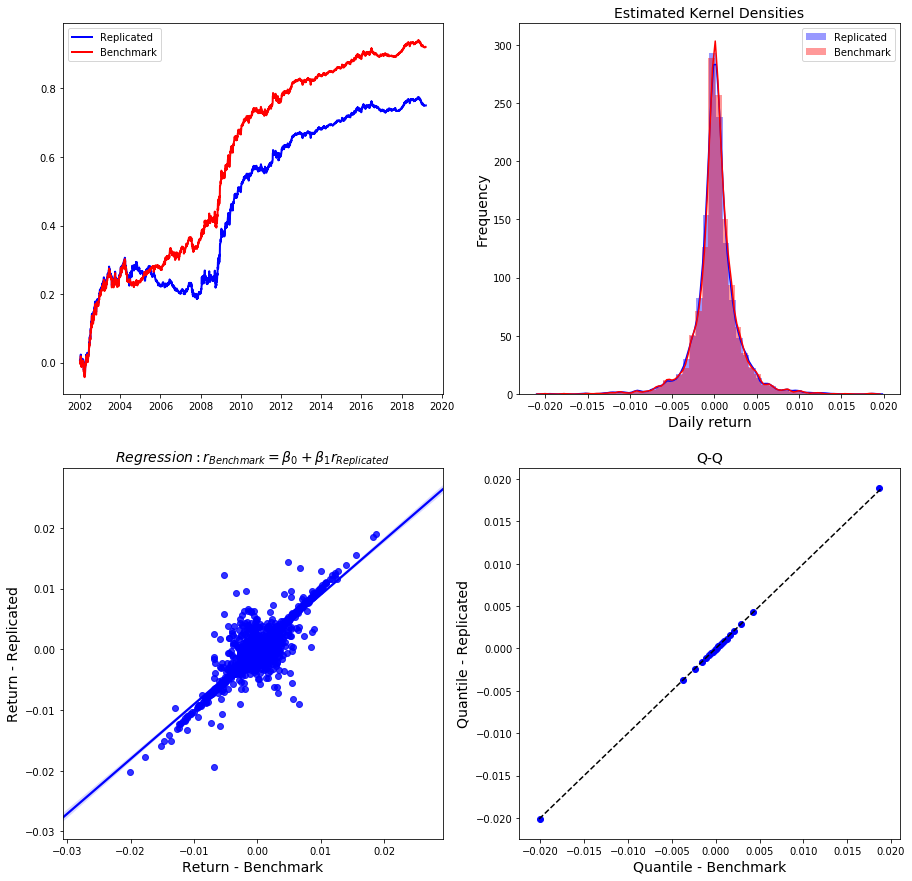

In [73]:
# Plot results
import seaborn as sns

start_date  = datetime(2001,12,31)

strategy_4_returns = strategy_4_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_4_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()


fig, ax = plt.subplots(2, 2, figsize=(15,15))


ax[0, 0].plot(strategy_4_returns.cumsum()  , label = 'Replicated', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

sns.distplot(strategy_4_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated')
sns.distplot(benchmark_returns   , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()


x_data = benchmark_returns.fillna(0)
y_data = strategy_4_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

# -------------------------------------------------------------------------------------------

# Signal 5 Performance Backtest

### Signal 5 definition:

Signal 5 is based on the cross over of short and longer exponentially weighted moving averages of the futures $\textit{prices}$. The algorithm building this signal involves several steps:

(a) Select 3 sets of time-scales with each set consisting of a short and a long ewmas.

(b) Here, we use the same specs as in MAN AHLs paper (link below). Let

$$S_k=\left( 8,16,32\right)$$
$$L_k=\left( 24,48,96\right)$$

These numbers are not look-back days or half-lifes but translate into EWMA decay factors $\lambda(n) = \frac{n-1}{n}$. So decay for the first short EWMA is $\lambda(S_1) = \frac{S_1-1}{S_1} = \frac{8-1}{8}$. Using this decay factor we compute the half-life of the EWMA:

$$HL(n) = \frac{log(0.5)}{log(\lambda(n))}$$

(c) Once we have obtained HLs for $S_k$ and $L_k$ we compute the cross over magnitudes $x_k$ in the usual manner:

$$x_k = EWMA\left(P|S_k\right) - EWMA\left(P|L_k\right)$$

where $P$ is the time-series for the price of the futures.

(d) The raw cross over signals $x_k$ is then normalized using a moving standard deviation of the $\textit{futures}$ $\textit{price}$ which is computed over 63-trading days:

$$y_k = \frac{x_k}{\sigma(P)_{63}}$$

Shameless plug warning:  https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf

(e) The standardized signal $y_k$ is standardized again using its own standard deviation computed over 252 trading days:

$$z_k = \frac{y_k}{\sigma(y_k)_{252}}$$

(f) The final signal $s$ is obtained by averaging the three standardized signals:

$$s=\frac{1}{3}\sum_{k=1}^{3} z_k $$

(g) Finally, we truncate the signal $s\in \left[ -1;1\right]$

### Nominal exposure

The final trading signal or $\textit{nominal exposure}$ of the strategy is computed using the raw trading signal and by multiplying it by 10.  That is, the total exposure in asset $i$ at time $t$, $E_{t}^{i}$ is defined as:

$$E_{t}^{i}:=10s_{t}^{i}$$

#### NOTE: No volatility scaling is used here


In [74]:
strategy_5_no_vol_scaling = pd.DataFrame(index = ret.index, data = np.zeros_like(ret), columns = ret.columns)

for symbol in symbols:
    
        # Momentum signal
        s = momentum_signals["Signal_5"][symbol]
        s = (s*index_specifications[symbol]["Signal_Scaling"]).to_frame()
        s.columns = [symbol]
        
        # Futures returns
        returns  = ret[symbol].to_frame()
        returns.columns = [symbol]
        
        # Strategy returns
        strategy_5_no_vol_scaling[symbol]  = returns*s.shift(1)              # without volatility scaling
   


Text(0.5,1,'Q-Q')

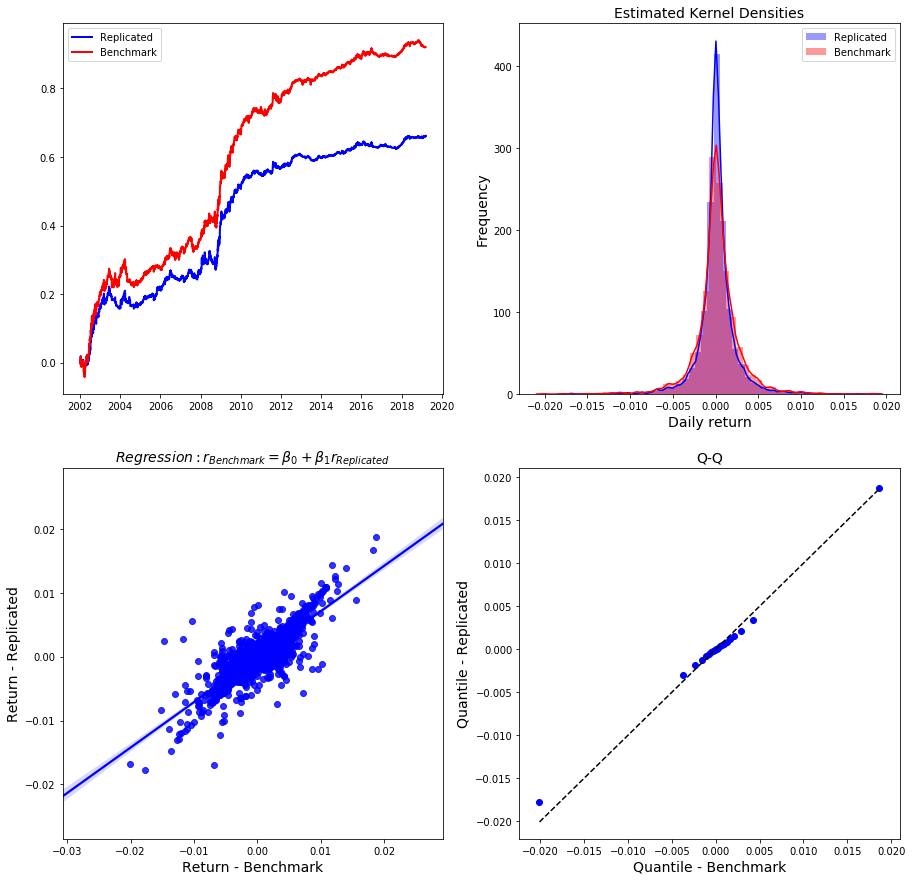

In [75]:
# Plot results
import seaborn as sns

start_date  = datetime(2001,12,31)

strategy_5_returns = strategy_5_no_vol_scaling.mean(axis=1).dropna().loc[start_date:].fillna(0)
strategy_sigma     = strategy_5_returns.std()

benchmark_returns = benchmark_data.pct_change(1).loc[start_date:].fillna(0)
benchmark_sigma   = benchmark_returns.std()


fig, ax = plt.subplots(2, 2, figsize=(15,15))


ax[0, 0].plot(strategy_5_returns.cumsum()  , label = 'Replicated', color = 'blue' , ls = '-' , lw = 2)
ax[0, 0].plot(benchmark_returns.cumsum() , label = 'Benchmark' , color = 'red' , ls = '-' , lw = 2)
ax[0, 0].set_ylabel('Cumulative performance', fontsize=14)
ax[0, 0].legend()

sns.distplot(strategy_5_returns  , ax = ax[0,1], color = 'blue', label = f'Replicated')
sns.distplot(benchmark_returns   , ax = ax[0,1], color = 'red' , label = 'Benchmark' )
ax[0,1].set_ylabel('Frequency', fontsize=14)
ax[0,1].set_xlabel('Daily return', fontsize=14)
ax[0,1].set_title('Estimated Kernel Densities', fontsize=14)
ax[0,1].legend()


x_data = benchmark_returns.fillna(0)
y_data = strategy_5_returns.loc[x_data.index].fillna(0)

sns.regplot(x = x_data.values, y = y_data.values, ax = ax[1,0], color = 'blue' )
ax[1,0].set_ylabel(f'Return - Replicated', fontsize=14)
ax[1,0].set_xlabel(f'Return - Benchmark', fontsize=14)
ax[1,0].set_title(r'$Regression: r_{Benchmark} = \beta_0 + \beta_1 r_{Replicated}$', fontsize=14)

percs = np.linspace(0,100,21)
qn_a  = np.percentile(x_data.values, percs)
qn_b  = np.percentile(y_data.values, percs)
x     = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax[1,1].plot(x,x, color="k", ls="--")
ax[1,1].scatter(qn_a,qn_b, marker="o", color = 'blue')
ax[1,1].set_ylabel(f'Quantile - Replicated', fontsize=14)
ax[1,1].set_xlabel(f'Quantile - Benchmark', fontsize=14)
ax[1,1].set_title('Q-Q', fontsize=14)

# Volatility Scaling Mechanism

In [ ]:
# Target volatility (per annum)
target_volatility = 0.08

# volatility calculation window
sigma_window = 60

# Lets compute the volatility leverages for each individual underlying
volatility_leverage = {}
for symbol in symbols:
    
    print('Computing volatility scaling for symbol: ', symbol)
    
    # Volatility scaling
    sigma_ratio = (target_volatility/(ret[symbol].rolling(sigma_window).std().dropna()*np.sqrt(250))).to_frame()
    sigma_ratio.columns = [symbol]
  
    volatility_leverage.update({symbol:sigma_ratio.copy()})

In [ ]:
df = pd.DataFrame(index = ret.index, data = np.zeros_like(ret), columns = ret.columns)
for symbol in symbols:
    l = volatility_leverage[symbol]
    r = ret[symbol].to_frame()
    r.columns = [symbol]
    df[symbol] = r.ewm(60).std()*np.sqrt(250)*l.shift(1)


In [ ]:
# Plot results
fig, ax = plt.subplots(8, 2, figsize=(15,30))

# Eurodollar futures 
#----------------------------------------------------------------------------------------------------------------------------
ax[0, 0].plot(volatility_leverage['ED1 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[0, 0].set_title(f"Volatility leverage for ED1" )
ax[0, 0].set_ylabel("Leverage",fontsize=14)

ax[0, 1].plot(df['ED1 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[0, 1].axhline(df['ED1 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[0, 1].set_title(f"Realized volatility for ED1 position" )
ax[0, 1].legend(fontsize=14)
ax[0, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

ax[1, 0].plot(volatility_leverage['ED2 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[1, 0].set_title(f"Volatility leverage for ED2" )
ax[1, 0].set_ylabel("Leverage",fontsize=14)

ax[1, 1].plot(df['ED2 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[1, 1].axhline(df['ED2 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[1, 1].set_title(f"Realized volatility for ED2 position" )
ax[1, 1].legend(fontsize=14)
ax[1, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

ax[2, 0].plot(volatility_leverage['ED3 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[2, 0].set_title(f"Volatility leverage for ED3" )
ax[2, 0].set_ylabel("Leverage",fontsize=14)

ax[2, 1].plot(df['ED3 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[2, 1].axhline(df['ED3 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[2, 1].set_title(f"Realized volatility for ED3 position" )
ax[2, 1].legend(fontsize=14)
ax[2, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

ax[3, 0].plot(volatility_leverage['ED4 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[3, 0].set_title(f"Volatility leverage for ED4" )
ax[3, 0].set_ylabel("Leverage",fontsize=14)

ax[3, 1].plot(df['ED4 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[3, 1].axhline(df['ED4 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[3, 1].set_title(f"Realized volatility for ED4 position" )
ax[3, 1].legend(fontsize=14)
ax[3, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

# Euribor futures 
#----------------------------------------------------------------------------------------------------------------------------
ax[4, 0].plot(volatility_leverage['ER1 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[4, 0].set_title(f"Volatility leverage for ER1" )
ax[4, 0].set_ylabel("Leverage",fontsize=14)

ax[4, 1].plot(df['ER1 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[4, 1].axhline(df['ER1 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[4, 1].set_title(f"Realized volatility for ER1 position" )
ax[4, 1].legend(fontsize=14)
ax[4, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

ax[5, 0].plot(volatility_leverage['ER2 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[5, 0].set_title(f"Volatility leverage for ER2" )
ax[5, 0].set_ylabel("Leverage",fontsize=14)

ax[5, 1].plot(df['ER2 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[5, 1].axhline(df['ER2 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[5, 1].set_title(f"Realized volatility for ER2 position" )
ax[5, 1].legend(fontsize=14)
ax[5, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

ax[6, 0].plot(volatility_leverage['ER3 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[6, 0].set_title(f"Volatility leverage for ER3" )
ax[6, 0].set_ylabel("Leverage",fontsize=14)

ax[6, 1].plot(df['ER3 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[6, 1].axhline(df['ER3 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[6, 1].set_title(f"Realized volatility for ER3 position" )
ax[6, 1].legend(fontsize=14)
ax[6, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)

ax[7, 0].plot(volatility_leverage['ER4 Comdty'], color = 'blue' , ls = '-', lw = 2)
ax[7, 0].set_title(f"Volatility leverage for ER4" )
ax[7, 0].set_ylabel("Leverage",fontsize=14)

ax[7, 1].plot(df['ER4 Comdty']            , label = "60d estimate" , color = 'blue' , ls = '-', lw = 2)
ax[7, 1].axhline(df['ER4 Comdty'].median(), label = "Median"      , color = 'red'  , ls = '-', lw = 2)
ax[7, 1].set_title(f"Realized volatility for ER4 position" )
ax[7, 1].legend(fontsize=14)
ax[7, 1].set_ylabel(r"Realized $\sigma$ (p.a.)",fontsize=14)
